In [3]:
# ---Import de librerias y configuracion---
import os
import pandas as pd
import matplotlib.pyplot as plt
from supabase import create_client, Client
from dotenv import load_dotenv

# Esta funcion es una medida de seguridad, carga las contraseñas desde el .env.
load_dotenv()

# --- Conexion y extraccion (ETL) ---

# 1. Obtenemos las credenciales
url = os.environ.get("SUPABASE_URL")
key = os.environ.get("SUPABASE_KEY")

# Inicia sesion en la base de datos
supabase: Client = create_client(url,key)

# 2. realizamos una peticion a la base de datos
#  le pedimos a la base de datos traer todas las columnas de la tabla monthly_tips
responde = supabase.table("monthly_tips").select("*").execute()

#3. Convertimos datos crudos en una tabla de pandas
df = pd.DataFrame(responde.data)

# 4. para que las grafica sea cronologica ordenamos por fecha
df = df.sort_values("month_label")

# Mostramos la tabla inicial para verificar
print("Tabla cruda descargada de supabase:")
display(df)

Tabla cruda descargada de supabase:


,id,month_label,total_trips,total_tip_amount,avg_tip,median_tip,stddev_tip,total_fare_amount,avg_tip_pct,source_file,created_at
0,1,01-2016,10902640,1.909498e+07,1.751409,0,0,1.362357e+08,14.016139,DataSet/yellow_tripdata_2016-01.csv,2025-12-09T05:36:39.718348+00:00
1,2,02-2016,11377755,2.017398e+07,1.773107,0,0,1.413420e+08,14.273166,DataSet/yellow_tripdata_2016-02.csv,2025-12-09T06:17:17.43098+00:00


In [5]:
# --- CÁLCULOS Y ENRIQUECIMIENTO DE DATOS ---

#  Preparación para el Análisis Básico (Totales)
#  Realizamos un redondeo(corta los decimales para solo dejar 2, para verlo como moneda)
df['total_tip_amount'] = df['total_tip_amount'].round(2)
df['total_fare_amount'] = df['total_fare_amount'].round(2)

print("\nANÁLISIS (TOTALES BRUTOS)")
# Mostramos solo las columnas originales
display(df[['month_label', 'total_trips', 'total_tip_amount']])


# Segundo analisis

# 1. Definimos los días de cada mes (2016 fue año bisiesto)
# creamos una regla explicitamente cuantos dias duro cada mes, en 2016 fue año bisiento
dias_por_mes = {'01-2016': 31, '02-2016': 29}

# 2. Mapeamos los días al DataFrame / necesitamos el numero (31 o 29) en la tabla para poder hacer divisiones
df['days_in_month'] = df['month_label'].map(dias_por_mes)

# 3. Calculamos la Eficiencia Diaria (Propinas / Días)
# 
df['tips_per_day'] = df['total_tip_amount'] / df['days_in_month']

# 4. Calculamos el Ticket Promedio (Costo promedio por viaje)
# Divide el costo total de todos los viajes (fare) entra la cantidad de viajes (trips) / precio promedio de un viaje
df['avg_fare'] = df['total_fare_amount'] / df['total_trips']

# Redondeamos las nuevas métricas
df['tips_per_day'] = df['tips_per_day'].round(2)
df['avg_fare'] = df['avg_fare'].round(2)

print("\n ANÁLISIs (EFICIENCIA Y PROMEDIOS)")
# Mostramos la tabla con las nuevas métricas calculadas
display(df[['month_label', 'days_in_month', 'tips_per_day', 'avg_fare']])


ANÁLISIS (TOTALES BRUTOS)


,month_label,total_trips,total_tip_amount
0,01-2016,10902640,19094978.50
1,02-2016,11377755,20173982.29



 ANÁLISIs (EFICIENCIA Y PROMEDIOS)


,month_label,days_in_month,tips_per_day,avg_fare
0,01-2016,31,615967.05,12.50
1,02-2016,29,695654.56,12.42


In [6]:
# INDICADORES DE TENDENCIA Y CALIDAD 

# 1. Calculamos la Tasa de Crecimiento Mensual (MoM)
# Usamos pct_change() para ver porcentualmente cuánto subió o bajó el negocio respecto al mes anterior.
# Multiplicamos por 100 para obtener el porcentaje legible.
df['growth_tips'] = df['total_tip_amount'].pct_change() * 100
df['growth_trips'] = df['total_trips'].pct_change() * 100

# 2. Calculamos la "Generosidad del Cliente" (Tip Rate)
# Dividimos el total de propinas entre el costo del viaje para saber qué porcentaje de la tarifa 
# suelen dejar los usuarios.
df['tip_percentage'] = (df['total_tip_amount'] / df['total_fare_amount']) * 100

# 3. Limpieza final 
# Redondeamos los decimales y llenamos con 0 los valores vacíos (NaN) que se generan en el primer mes
# (ya que Enero no tiene un mes anterior contra el cual compararse).
df['growth_tips'] = df['growth_tips'].round(2)
df['growth_trips'] = df['growth_trips'].round(2)
df['tip_percentage'] = df['tip_percentage'].round(2)
df = df.fillna(0)

print("\nINDICADORES DE TENDENCIA Y CALIDAD")
print("Nota: Un valor negativo en 'growth' indica una caída respecto al mes previo.")
display(df[['month_label', 'growth_trips', 'growth_tips', 'tip_percentage']])


INDICADORES DE TENDENCIA Y CALIDAD
Nota: Un valor negativo en 'growth' indica una caída respecto al mes previo.


,month_label,growth_trips,growth_tips,tip_percentage
0,01-2016,0.00,0.00,14.02
1,02-2016,4.36,5.65,14.27


NameError: name 'df' is not defined

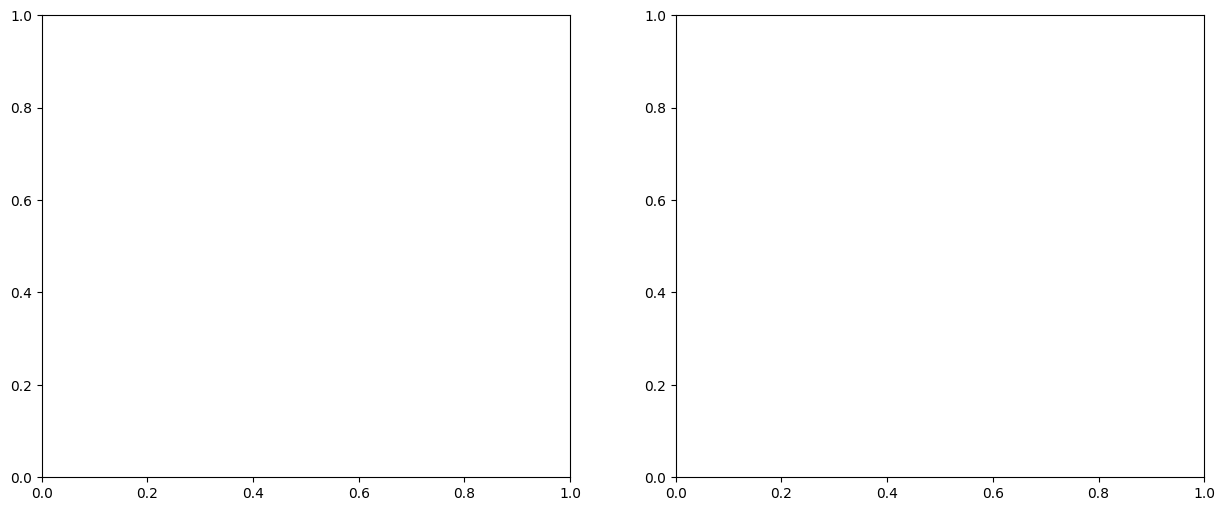

In [2]:
#  VISUALIZACIÓN COMPARATIVA FINAL 

# 1. Configuración del "Lienzo"
# Creamos una figura (fig) que contendrá 2 gráficos uno al lado del otro (subplots 1, 2).
# Ajustamos el tamaño a 15x6 pulgadas para que se vean amplios y legibles.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

#  TOTALES BRUTOS 
# Usamos el objeto ax1 para dibujar barras. Color 'skyblue' para que sea agradable a la vista.
barras1 = ax1.bar(df['month_label'], df['total_tip_amount'], color='skyblue')

# Añadimos títulos y etiquetas para que cualquiera entienda el gráfico sin explicación.
ax1.set_title('Comparación Total de Ingresos (Propinas)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Total en USD', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.5) # Líneas guía suaves de fondo

# Etiquetado de valores (Data Labels)
# Recorremos cada barra para escribir el monto exacto encima de ella.
# Usamos f"${v:,.0f}" para dar formato de moneda sin decimales 
for barra in barras1:
    height = barra.get_height()
    ax1.text(barra.get_x() + barra.get_width()/2, height,
             f"${height:,.0f}", ha='center', va='bottom', fontsize=11)


#  EFICIENCIA DIARIA
# Usamos ax2 para el segundo gráfico. Usamos color 'salmon' para diferenciarlo visualmente.
barras2 = ax2.bar(df['month_label'], df['tips_per_day'], color='salmon')

ax2.set_title('Eficiencia Real: Promedio de Propinas por Día', fontsize=14, fontweight='bold')
ax2.set_ylabel('Promedio Diario (USD)', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.5)

# Etiquetado de valores para el segundo gráfico
for barra in barras2:
    height = barra.get_height()
    ax2.text(barra.get_x() + barra.get_width()/2, height,
             f"${height:,.0f}", ha='center', va='bottom', fontsize=11)

# Ajuste final
# plt.tight_layout() ajusta automáticamente los márgenes para que los textos no se superpongan.
plt.tight_layout()

# Mostramos el resultado final
plt.show()